In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc,  precision_recall_curve, average_precision_score
import math
import time
import os
from PIL import Image
import matplotlib.pyplot as plt


# Define our example directories and files
IMAGE_SIZE = [224, 224]

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   validation_split=0.15,
                                   featurewise_center=False,
                                   samplewise_center=False,
                                   featurewise_std_normalization=False,
                                   samplewise_std_normalization=False,
                                   zca_whitening=False,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip=False
                                  )

# Note that the testing data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory('/kaggle/input/dataset-for-different-eye-disease/DATASET_101/Train',
                                                    target_size = (224, 224),
                                                    batch_size = 64,
                                                    subset = "training",
                                                    class_mode = 'categorical',
                                                    color_mode = 'rgb'       
                                                   )

# Flow validation images in batches of 32 using train_datagen generator
validation_generator = train_datagen.flow_from_directory('/kaggle/input/dataset-for-different-eye-disease/DATASET_101/Train',
                                                         target_size = (224, 224),
                                                         batch_size = 64,
                                                         subset = "validation",
                                                         class_mode = 'categorical',
                                                         color_mode = 'rgb'      
                                                        )

# Flow testing images in batches of 32 using test_datagen generator
test_generator = test_datagen.flow_from_directory('/kaggle/input/dataset-for-different-eye-disease/DATASET_101/Test',
                                                  target_size = (224, 224),
                                                  batch_size  = 64,
                                                  class_mode  = 'categorical',
                                                  color_mode = 'rgb',       
                                                  shuffle = False
                                                 )

Found 7167 images belonging to 6 classes.
Found 1262 images belonging to 6 classes.
Found 1395 images belonging to 6 classes.


In [2]:
from tqdm import tqdm
import numpy as np
y_test = []
y_test_int = []
for i in tqdm(range(len(test_generator))):
    y_test += test_generator[i][1].tolist()
    y_test_int += test_generator[i][1].argmax(axis=1).tolist()

y_test = np.array(y_test)
y_test_int = np.array(y_test_int)

100%|██████████| 22/22 [01:25<00:00,  3.87s/it]


In [3]:
def get_callbacks(model_name):
    callbacks =[]

    # Create callbacks outside the function to avoid creating variables inside a tf.function
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'model.{model_name}.keras', verbose=1, monitor='val_loss',mode='min',save_best_only=True)
    anne = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=2, min_lr=0.0000001,min_delta=0.00001,mode='auto')
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

    callbacks.append(checkpoint)
    callbacks.append(anne)
    callbacks.append(earlystop)

    return callbacks

****** **DenseNet121** ******

In [4]:
from tensorflow.keras.applications import DenseNet121
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Load the DenseNet121 model pre-trained on ImageNet
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[120:]:
   layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(6, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(loss ='categorical_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy'])#, keras.metrics.Precision(), #keras.metrics.Recall(),# keras.metrics.SpecificityAtSensitivity(0.5), #keras.metrics.SensitivityAtSpecificity(0.5)])
# Print the model summary
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,043,654 (26.87 MB)

 Trainable params: 1,071,942 (4.09 MB)

 Non-trainable params: 5,971,712 (22.78 MB)

In [5]:
callbacks = get_callbacks('dense121')
history = model.fit( train_generator,epochs=50,
                    validation_data= validation_generator,
                    callbacks=callbacks) 

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727129319.358633      92 service.cc:145] XLA service 0x7f1ba4003850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727129319.358687      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1727129319.358691      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1727129370.761952      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8844 - loss: 0.3575
Epoch 1: val_loss improved from inf to 1.28462, saving model to model.dense121.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 494s 4s/step - accuracy: 0.8849 - loss: 0.3561 - val_accuracy: 0.4778 - val_loss: 1.2846 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9589 - loss: 0.1173
Epoch 2: val_loss improved from 1.28462 to 0.42894, saving model to model.dense121.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.9589 - loss: 0.1173 - val_accuracy: 0.8851 - val_loss: 0.4289 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9613 - loss: 0.1012
Epoch 3: val_loss did not improve from 0.42894
112/112 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - accuracy: 0.9613 - loss: 0.1012 - val_accuracy: 0.8542 - val_loss: 0.7656 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9643 - loss: 0.0920
Epoch 4: val_loss did no

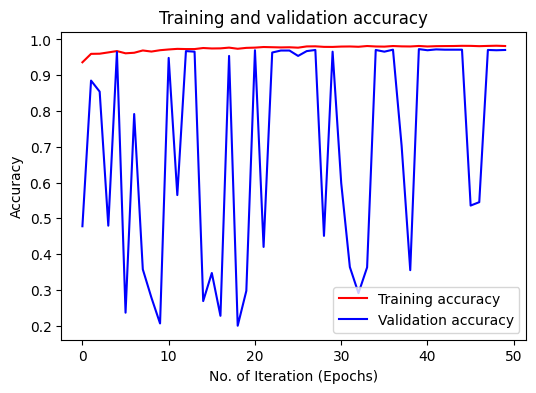

<Figure size 640x480 with 0 Axes>

In [6]:
# accuracies
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('No. of Iteration (Epochs)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.savefig('train_val_acc.png')

In [7]:
# Generate predictions using the model
Y_pred = model.predict(test_generator)  # Assuming test_generator yields batches of data
y_pred = np.argmax(Y_pred, axis=1)

# Print confusion matrix
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

# Print classification report
target_names = ['ACRIMA', 'Glaucoma', 'ODIR-5K', 'ORIGA', 'cataract', 'retina_disease']
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, digits=4))

22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step
Confusion Matrix
[[ 144    0    1    0    0    0]
 [   0   20    0   28    1    8]
 [   0    0 1000    0    0    0]
 [   0    0    0  133    0    0]
 [   0    0    2    0   21    7]
 [   0    2    0    0    5   23]]
Classification Report
                precision    recall  f1-score   support

        ACRIMA     1.0000    0.9931    0.9965       145
      Glaucoma     0.9091    0.3509    0.5063        57
       ODIR-5K     0.9970    1.0000    0.9985      1000
         ORIGA     0.8261    1.0000    0.9048       133
      cataract     0.7778    0.7000    0.7368        30
retina_disease     0.6053    0.7667    0.6765        30

      accuracy                         0.9613      1395
     macro avg     0.8525    0.8018    0.8032      1395
  weighted avg     0.9643    0.9613    0.9567      1395



In [8]:
number_of_examples = len(test_generator.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 64))
# 1.0 above is to skip integer division

test_labels = []
test_images = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_generator[i][1]))

for i in range(0,int(number_of_generator_calls)):
    test_images.extend(np.array(test_generator[i][0]))
    %matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
predictions = model.predict(test_generator)
new_labels = []
for i in range(0,1395):
  new_labels.append(np.argmax(predictions[i]))
newtest_labels = []
for i in range(0,1395):
  newtest_labels.append(np.argmax(test_labels[i]))
cm = confusion_matrix(y_true=newtest_labels, y_pred=new_labels)

22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step


Accuracy score: 0.9612903225806452
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
AUC: 0.9729616777373966


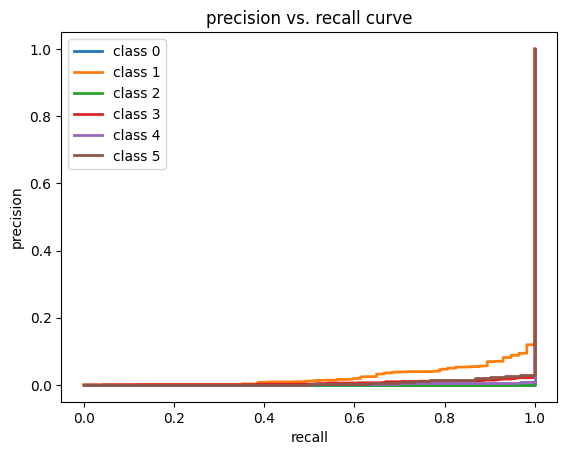

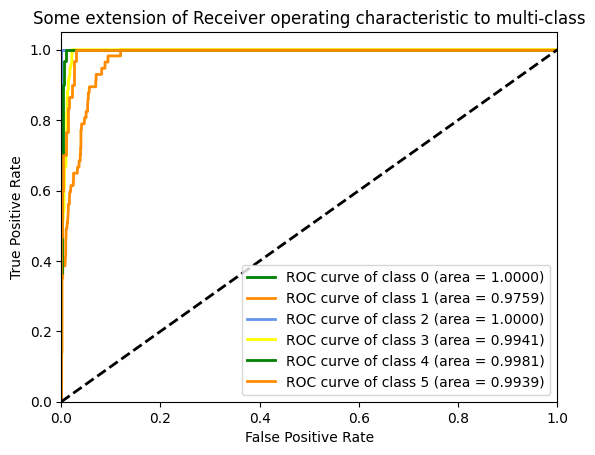

In [9]:
# Calculate accuracy score
score = metrics.accuracy_score(newtest_labels, new_labels)
print("Accuracy score: {}".format(score))

# Generate prediction probabilities
pred_prob = model.predict(test_generator)

# Calculate ROC AUC score
c = roc_auc_score(newtest_labels, pred_prob, multi_class='ovo')
print("AUC:", c)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
lw = 2
precision = {}
recall = {}

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(newtest_labels, pred_prob[:, i], pos_label=i)
    precision[i], recall[i], _ = roc_curve(newtest_labels, pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.savefig('prc.png')
plt.show()

n_classes = 6

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally, average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

colors = cycle(['green', 'darkorange', 'cornflowerblue', 'yellow' ])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.4f})'
                                                       ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('ssr.png')
plt.show()

# **xception******

In [10]:
OPTIMIZER =Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
base_model=tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=(224, 224, 3))
for layer in base_model.layers[50:]:
   layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = tf.keras.layers.Dense(6, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss ='categorical_crossentropy',optimizer=OPTIMIZER,metrics=['accuracy'])#, keras.metrics.Precision(), #keras.metrics.Recall(),# keras.metrics.SpecificityAtSensitivity(0.5), #keras.metrics.SensitivityAtSpecificity(0.5)])
# Print the model summary
model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer_1[0]… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 20,873,774 (79.63 MB)

 Trainable params: 3,271,022 (12.48 MB)

 Non-trainable params: 17,602,752 (67.15 MB)

In [11]:
callbacks = get_callbacks('Xception')
history = model.fit( train_generator,epochs=50,
                    validation_data= validation_generator,
                    callbacks=callbacks) 

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9024 - loss: 0.3023
Epoch 1: val_loss improved from inf to 0.28428, saving model to model.Xception.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 396s 3s/step - accuracy: 0.9028 - loss: 0.3010 - val_accuracy: 0.9231 - val_loss: 0.2843 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9717 - loss: 0.0819
Epoch 2: val_loss improved from 0.28428 to 0.08710, saving model to model.Xception.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 296s 3s/step - accuracy: 0.9717 - loss: 0.0818 - val_accuracy: 0.9643 - val_loss: 0.0871 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9734 - loss: 0.0673
Epoch 3: val_loss did not improve from 0.08710
112/112 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.9734 - loss: 0.0673 - val_accuracy: 0.9572 - val_loss: 0.1474 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9712 - loss: 0.0759
Epoch 4: val_

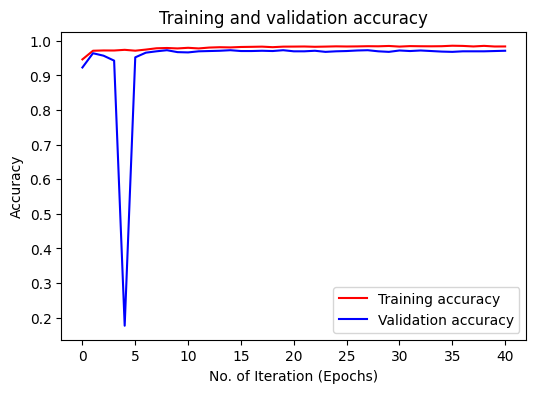

<Figure size 640x480 with 0 Axes>

In [12]:
# accuracies
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('No. of Iteration (Epochs)')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.savefig('train_val_acc.png')

In [13]:
# Generate predictions using the model
Y_pred = model.predict(test_generator)  # Assuming test_generator yields batches of data
y_pred = np.argmax(Y_pred, axis=1)

# Print confusion matrix
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

# Print classification report
target_names = ['ACRIMA', 'Glaucoma', 'ODIR-5K', 'ORIGA', 'cataract', 'retina_disease']
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=target_names, digits=4))

22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step
Confusion Matrix
[[ 145    0    0    0    0    0]
 [   0   23    0   30    1    3]
 [   0    0 1000    0    0    0]
 [   0    1    0  132    0    0]
 [   0    4    0    0   24    2]
 [   0    4    0    0    4   22]]
Classification Report
                precision    recall  f1-score   support

        ACRIMA     1.0000    1.0000    1.0000       145
      Glaucoma     0.7188    0.4035    0.5169        57
       ODIR-5K     1.0000    1.0000    1.0000      1000
         ORIGA     0.8148    0.9925    0.8949       133
      cataract     0.8276    0.8000    0.8136        30
retina_disease     0.8148    0.7333    0.7719        30

      accuracy                         0.9649      1395
     macro avg     0.8627    0.8216    0.8329      1395
  weighted avg     0.9632    0.9649    0.9613      1395



In [14]:
number_of_examples = len(test_generator.filenames)
number_of_generator_calls = math.ceil(number_of_examples / (1.0 * 64))
# 1.0 above is to skip integer division

test_labels = []
test_images = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_generator[i][1]))

for i in range(0,int(number_of_generator_calls)):
    test_images.extend(np.array(test_generator[i][0]))
    %matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
predictions = model.predict(test_generator)
new_labels = []
for i in range(0,1395):
  new_labels.append(np.argmax(predictions[i]))
newtest_labels = []
for i in range(0,1395):
  newtest_labels.append(np.argmax(test_labels[i]))
cm = confusion_matrix(y_true=newtest_labels, y_pred=new_labels)

22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step


Accuracy score: 0.9648745519713262
22/22 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
AUC: 0.9688920212812734


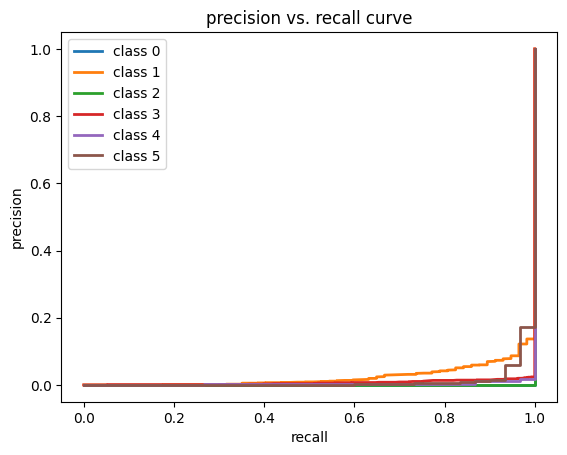

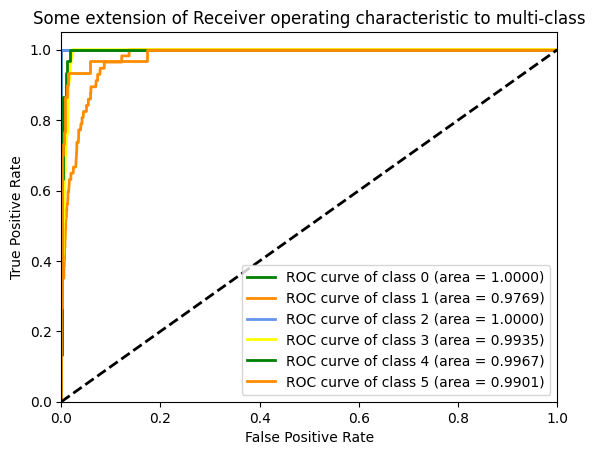

In [15]:
# Calculate accuracy score
score = metrics.accuracy_score(newtest_labels, new_labels)
print("Accuracy score: {}".format(score))

# Generate prediction probabilities
pred_prob = model.predict(test_generator)

# Calculate ROC AUC score
c = roc_auc_score(newtest_labels, pred_prob, multi_class='ovo')
print("AUC:", c)

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}
lw = 2
precision = {}
recall = {}

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(newtest_labels, pred_prob[:, i], pos_label=i)
    precision[i], recall[i], _ = roc_curve(newtest_labels, pred_prob[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(recall[i], precision[i], lw=2, label='class {}'.format(i))

plt.xlabel("recall")
plt.ylabel("precision")
plt.legend(loc="best")
plt.title("precision vs. recall curve")
plt.savefig('prc.png')
plt.show()

n_classes = 6

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally, average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()

colors = cycle(['green', 'darkorange', 'cornflowerblue', 'yellow' ])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.4f})'
                                                       ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('ssr.png')
plt.show()